# Change Point Identification
- ported from python
- to detect change points in the time series of log(var) of gh500 in the North Atlantic
- use monthly data for simplicity and because spatial aggregation makes daily scale inconsistent

In [13]:
source("../RScripts/config.r")
source("../RScripts/plot_functions.r")
source("../RScripts/data_functions.r")
source("../RScripts/algo_functions.r")

options(repr.plot.width = 15, repr.plot.height = 10) # Adjust width & height


## Data preprocessing

In [2]:
# List netCDF files matching the pattern "spread_*.nc"
spread_files <- list.files(
    path = DATA_DIR,
    pattern = "^spread_.*\\.nc$",
    full.names = TRUE
)

spread_files <- sort(spread_files)
extract_year <- function(file_name) {
    # Extract the year (digits after last '_' and before '.nc')
    base <- basename(file_name)
    m <- regexpr("_(\\d+)\\.nc$", base, perl = TRUE)
    year_str <- regmatches(base, m)
    year_str <- sub("^_", "", year_str)
    year_str <- sub("\\.nc$", "", year_str)
    as.integer(year_str)
}

years <- sapply(spread_files, extract_year)


In [3]:
# Compute monthly averages for each file
monthly_averages <- lapply(spread_files, calculate_monthly_averages)

# Combine the per-file datasets into one data frame
combined_dataset <- combine_datasets(monthly_averages, years) %>% mutate(
    log_variance = log(avg_z),
    sin_mon = sin(2 * pi * month / 12),
    cos_mon = cos(2 * pi * month / 12)
)

combined_dataset$date <- as.Date(with(
    combined_dataset,
    paste(year, month, "01", sep = "-")
))

str(combined_dataset)


tibble [1,019 × 7] (S3: tbl_df/tbl/data.frame)
 $ month       : num [1:1019] 1 2 3 4 5 6 7 8 9 10 ...
 $ avg_z       : num [1:1019] 114006 84907 73049 98974 77988 ...
 $ year        : int [1:1019] 1940 1940 1940 1940 1940 1940 1940 1940 1940 1940 ...
 $ log_variance: num [1:1019] 11.6 11.3 11.2 11.5 11.3 ...
 $ sin_mon     : num [1:1019] 0.5 0.866 1 0.866 0.5 ...
 $ cos_mon     : num [1:1019] 8.66e-01 5.00e-01 6.12e-17 -5.00e-01 -8.66e-01 ...
 $ date        : Date[1:1019], format: "1940-01-01" "1940-02-01" ...


# Look at Seasonality of Dataset
- fit segmented model allowing annual change
- box-whiskers plot for each month along with a best fit sin-cos

In [6]:
ordered_cp_df <- function(bp_est_monthly, data) {
    # Get summary and confidence intervals
    bp_summary <- summary(bp_est_monthly)
    ci_bp_monthly <- confint(bp_est_monthly, level = 0.99)

    # Extract breakpoints
    cp_indices <- bp_summary$breakpoints[length(bp_est_monthly$breakpoints), ]

    # Compute NA counts for ordering and filter non-NA values
    na_counts <- colSums(is.na(bp_summary$breakpoints))
    valid_indices <- !is.na(cp_indices)
    ordered_indices <- order(na_counts[valid_indices], decreasing = FALSE)
    cp_indices_ordered <- cp_indices[valid_indices][ordered_indices]

    # Convert indices to dates
    matched_indices <- match(cp_indices_ordered, ci_bp_monthly$confint[, 2])
    cp_dates <- data$date[cp_indices_ordered]
    cp_dates_lower <- data$date[ci_bp_monthly$confint[matched_indices, 1]]
    cp_dates_upper <- data$date[ci_bp_monthly$confint[matched_indices, 3]]

    # Create ordered change point data frame
    cp_df <- data.frame(
        cp_date = cp_dates,
        cp_date_lower = cp_dates_lower,
        cp_date_upper = cp_dates_upper,
        cp_no = seq_along(cp_dates) # Identifier for the change points
    )

    return(cp_df)
}



	 Confidence intervals for breakpoints
	 of optimal 6-segment partition: 

Call:
confint.breakpointsfull(object = bp_est_monthly_no_seas, level = 0.99)

Breakpoints at observation number:
  0.5 % breakpoints 99.5 %
1    93         101    103
2   220         221    223
3   468         470    471
4   699         700    703
5   824         825    829

Corresponding to breakdates:
       0.5 % breakpoints    99.5 %
1 0.09126595  0.09911678 0.1010795
2 0.21589794  0.21687929 0.2188420
3 0.45927380  0.46123651 0.4622179
4 0.68596663  0.68694799 0.6898921
5 0.80863592  0.80961727 0.8135427


cp_date,cp_date_lower,cp_date_upper,cp_no
<date>,<date>,<date>,<int>
1958-05-01,1958-04-01,1958-07-01,1
1998-04-01,1998-03-01,1998-07-01,2
1979-02-01,1978-12-01,1979-03-01,3
1948-05-01,1947-09-01,1948-07-01,4
2008-09-01,2008-08-01,2009-01-01,5


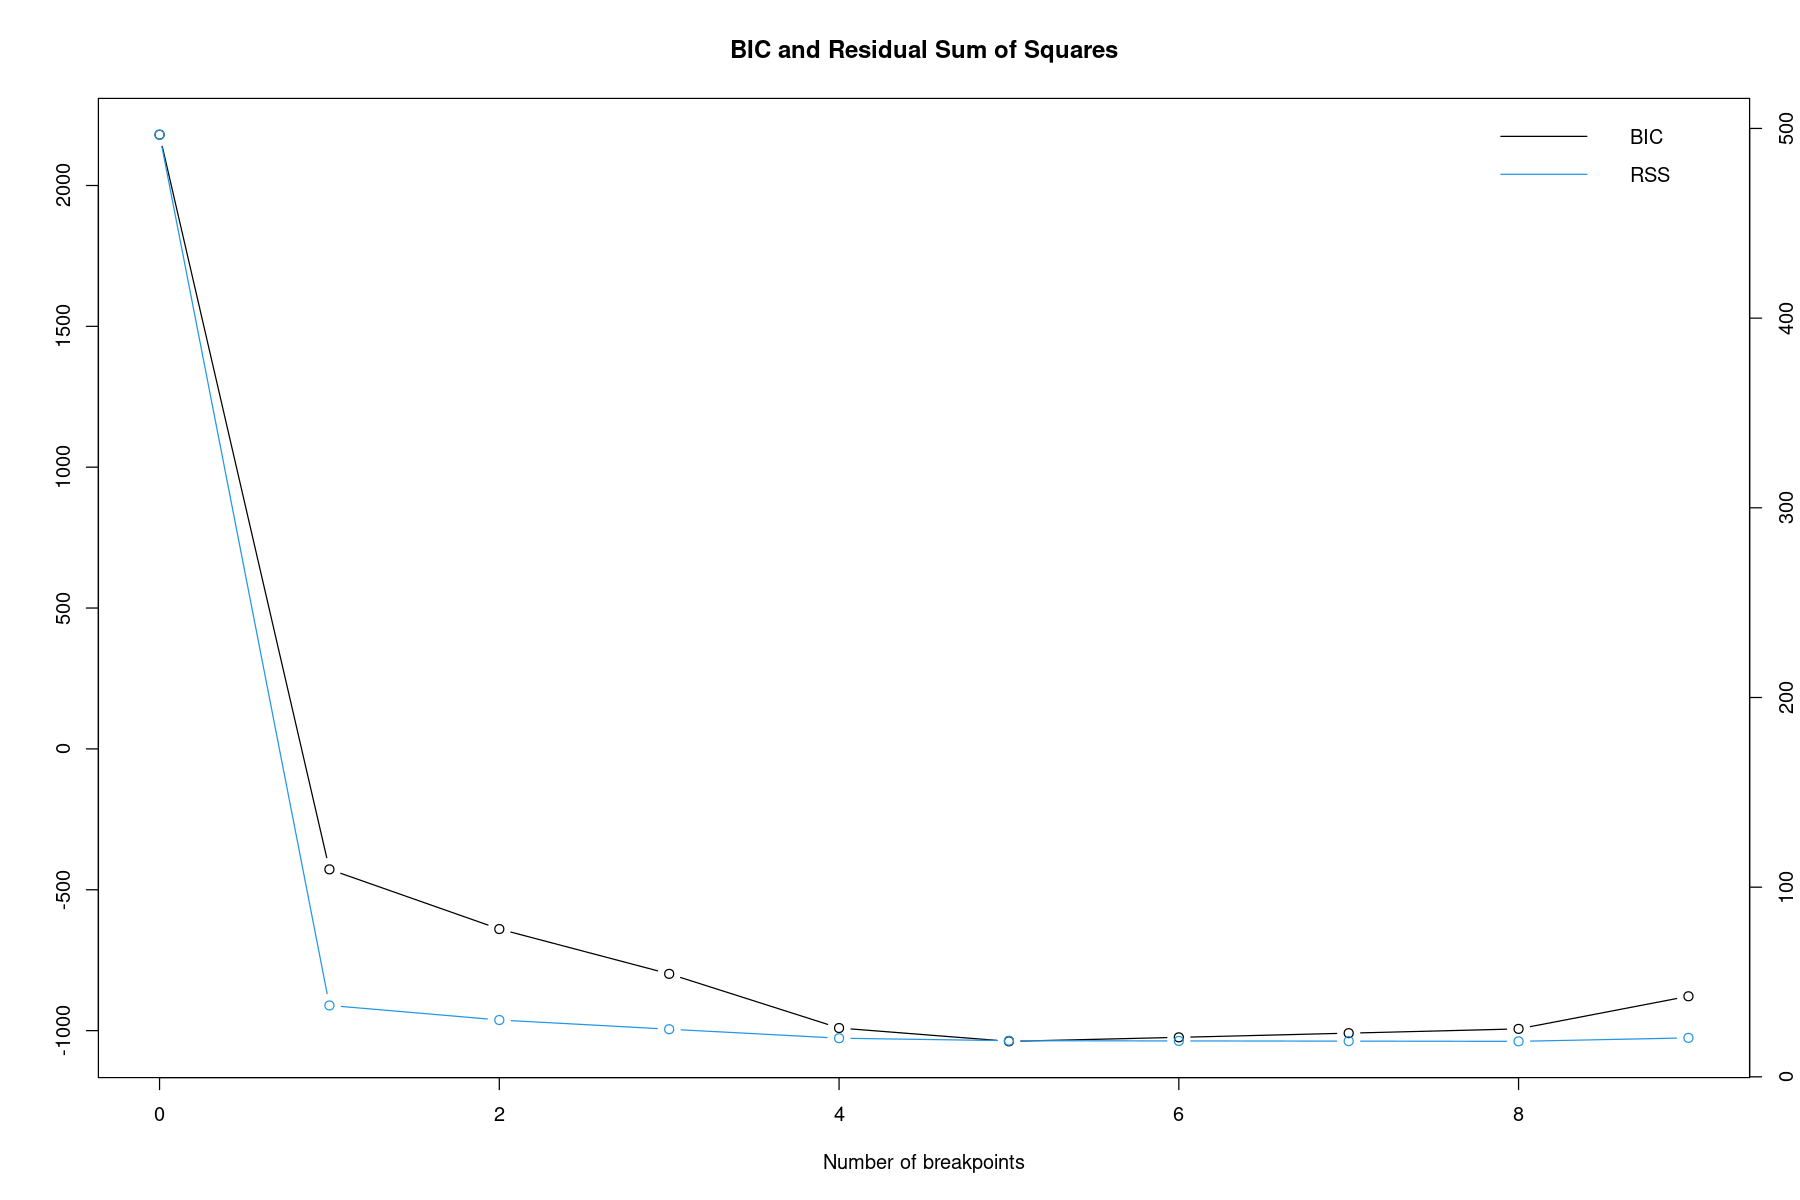

In [7]:
model_formula <- (log_variance ~ year)
# Estimate breakpoints
bp_est_monthly_no_seas <- breakpoints(model_formula,
    data = combined_dataset,
    h = .1
)
par(bg = "white")
plot(bp_est_monthly_no_seas)
print(confint(bp_est_monthly_no_seas, level = 0.99))

cp_df <- ordered_cp_df(bp_est_monthly_no_seas, combined_dataset)
cp_df


In [9]:
combined_dataset$segment_no_seas <- breakfactor(bp_est_monthly_no_seas)


# Fit the segmented linear model with segment-specific predictors
lmod_monthly_no_seas <- lm(
    log_variance ~ segment_no_seas +
        segment_no_seas:year - 1,
    data = combined_dataset
)

# Summarize the segmented model results
summary(lmod_monthly_no_seas)



Call:
lm(formula = log_variance ~ segment_no_seas + segment_no_seas:year - 
    1, data = combined_dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.65948 -0.08665 -0.00931  0.08454  0.54657 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
segment_no_seassegment1      508.672051  10.953251  46.440  < 2e-16 ***
segment_no_seassegment2      378.676747   8.445621  44.837  < 2e-16 ***
segment_no_seassegment3       58.336553   2.870637  20.322  < 2e-16 ***
segment_no_seassegment4       42.013137   3.266157  12.863  < 2e-16 ***
segment_no_seassegment5      124.766928   8.173260  15.265  < 2e-16 ***
segment_no_seassegment6       26.826257   4.277715   6.271 5.31e-10 ***
segment_no_seassegment1:year  -0.256321   0.005635 -45.486  < 2e-16 ***
segment_no_seassegment2:year  -0.189861   0.004325 -43.902  < 2e-16 ***
segment_no_seassegment3:year  -0.026160   0.001458 -17.937  < 2e-16 ***
segment_no_seassegment4:year  -0.018123   0.001643 -

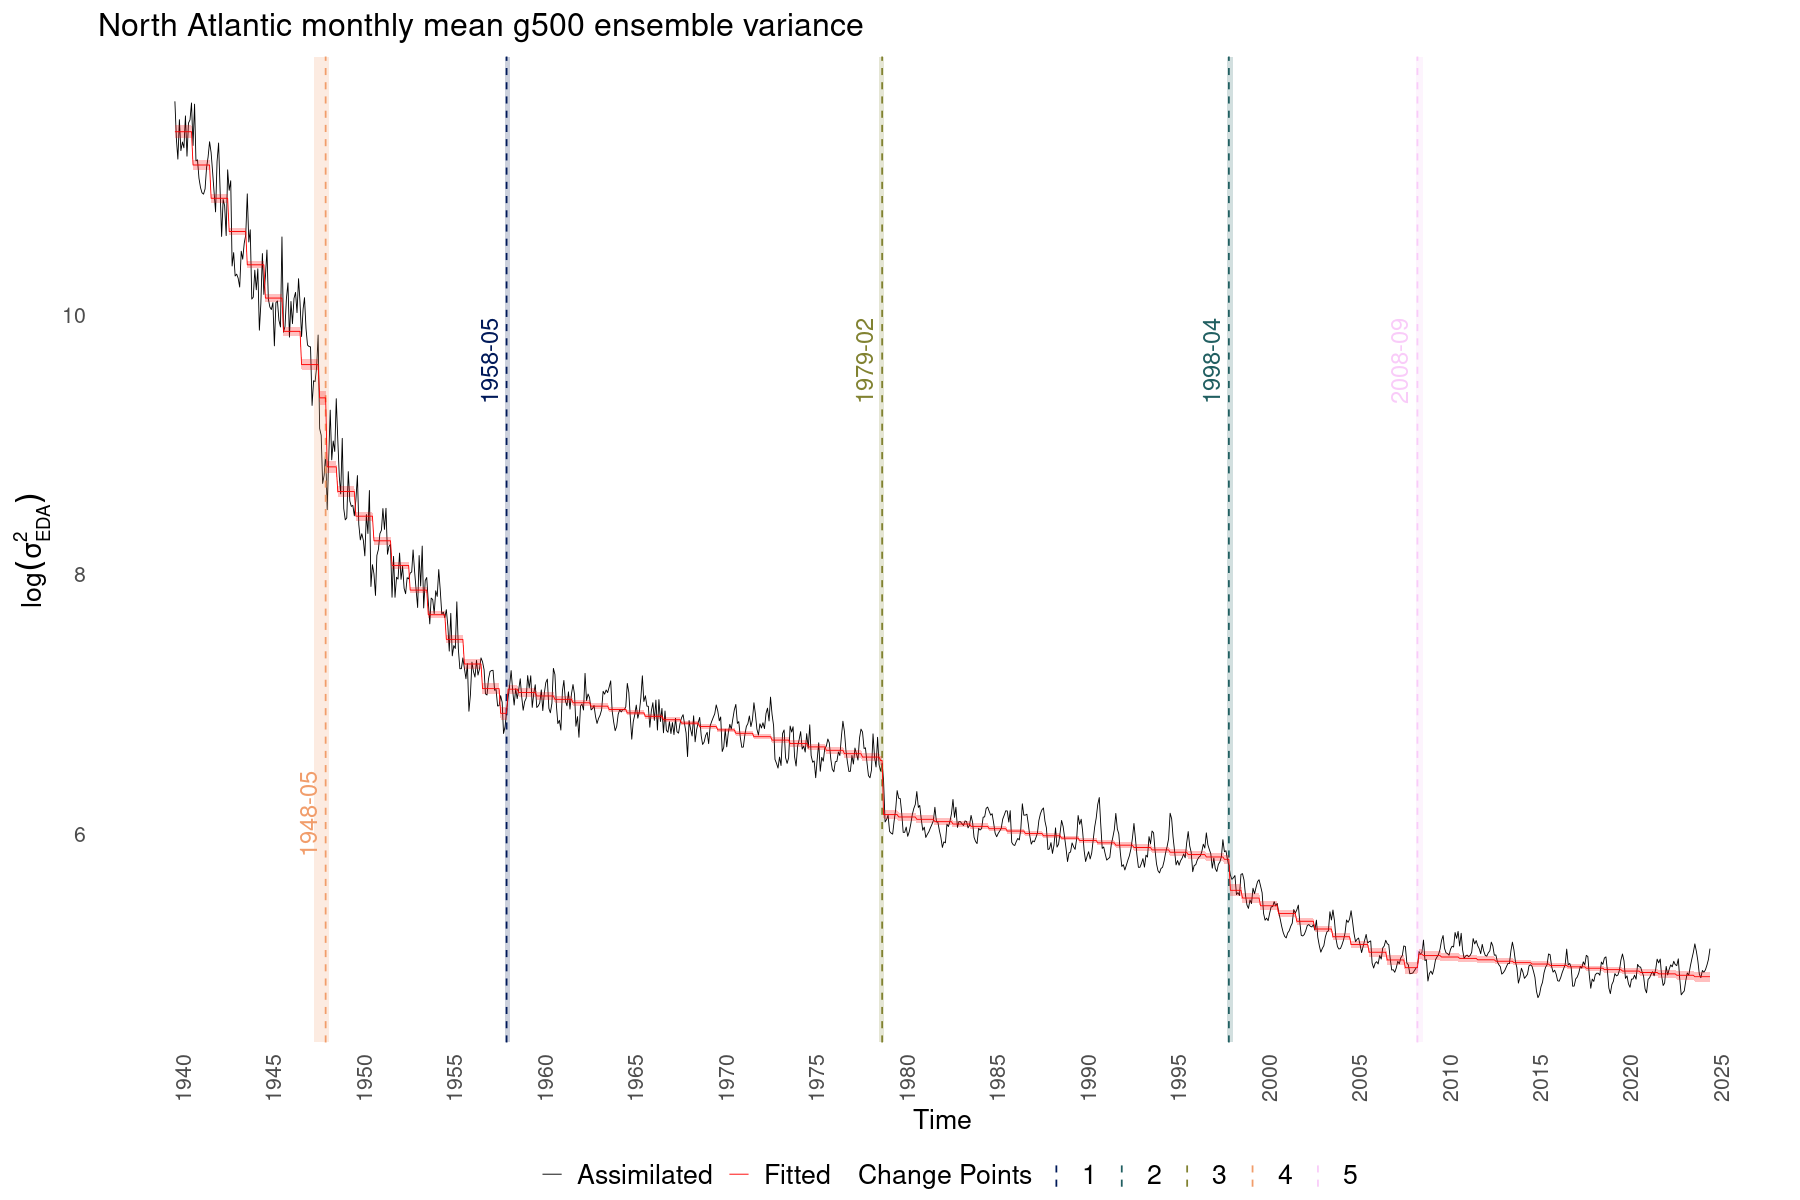

In [15]:
p <- plot_change_points(
    data = combined_dataset,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE
)

fitted_layers <- add_fitted_line_ci(lmod_monthly_no_seas, combined_dataset)
for (layer in fitted_layers) {
    p <- p + layer
}

# Optional: Combine the legends for size and linetype into one "Data" legend
p <- p + guides(
    size = guide_legend(order = 1),
    linetype = guide_legend(order = 2),
    color = guide_legend(order = 3)
)

p + THEME_PUB_LARGE


In [24]:
combined_dataset$residuals_no_seas <- residuals(lmod_monthly_no_seas)
str(combined_dataset)


tibble [1,019 × 9] (S3: tbl_df/tbl/data.frame)
 $ month            : num [1:1019] 1 2 3 4 5 6 7 8 9 10 ...
 $ avg_z            : num [1:1019] 114006 84907 73049 98974 77988 ...
 $ year             : int [1:1019] 1940 1940 1940 1940 1940 1940 1940 1940 1940 1940 ...
 $ log_variance     : num [1:1019] 11.6 11.3 11.2 11.5 11.3 ...
 $ sin_mon          : num [1:1019] 0.5 0.866 1 0.866 0.5 ...
 $ cos_mon          : num [1:1019] 8.66e-01 5.00e-01 6.12e-17 -5.00e-01 -8.66e-01 ...
 $ date             : Date[1:1019], format: "1940-01-01" "1940-02-01" ...
 $ segment_no_seas  : Factor w/ 6 levels "segment1","segment2",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ residuals_no_seas: Named num [1:1019] 0.234 -0.0607 -0.2111 0.0926 -0.1457 ...
  ..- attr(*, "names")= chr [1:1019] "1" "2" "3" "4" ...


In [26]:
seasonal_model_res <- lm(
    residuals_no_seas ~ sin_mon + cos_mon,
    data = combined_dataset
)


In [36]:
seasonal_pred


1           2           3           4           5           6 
 0.07509918  0.05221164  0.01535449 -0.02559643 -0.05966834 -0.07773171 
          7           8           9          10          11          12 
-0.07494647 -0.05205892 -0.01520177  0.02574914  0.05982105  0.07788442

In [39]:
# Create predictions for smooth seasonal curve
month_seq <- seq(1, 12, length.out = 12)
seasonal_pred <- predict(seasonal_model_res,
    newdata = data.frame(
        sin_mon = sin(2 * pi * month_seq / 12),
        cos_mon = cos(2 * pi * month_seq / 12)
    ),
    interval = "confidence",
    level = 0.95
)
seasonal_df <- data.frame(
    month = month_seq,
    fit = seasonal_pred[, "fit"],
    lwr = seasonal_pred[, "lwr"],
    upr = seasonal_pred[, "upr"]
)


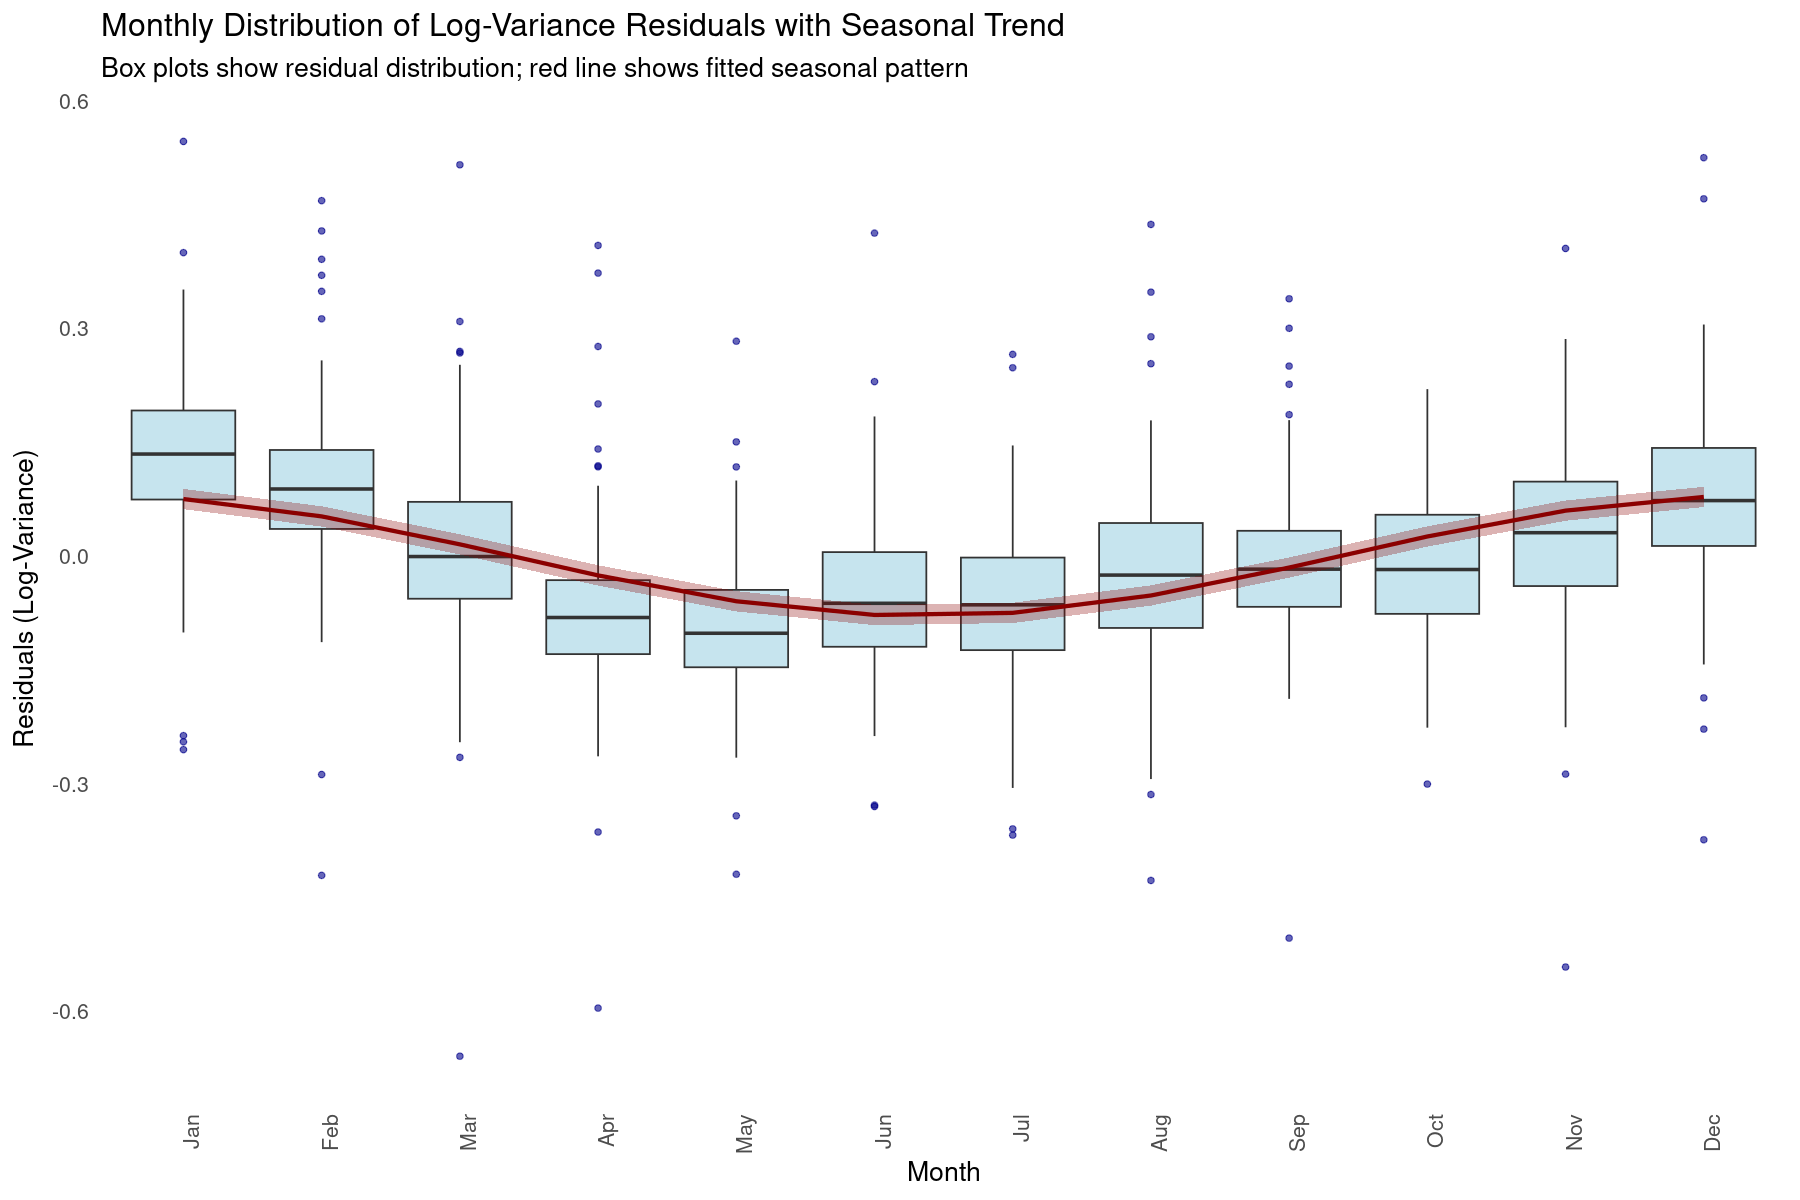

In [42]:
p <- ggplot(combined_dataset, aes(x = factor(month))) +
    # Box plots for residuals by month
    geom_boxplot(aes(y = residuals_no_seas),
        alpha = 0.7,
        fill = "lightblue",
        outlier.color = "darkblue",
        outlier.alpha = 0.6
    ) +
    geom_ribbon(
        data = seasonal_df,
        aes(x = month, ymin = lwr, ymax = upr, group = 1),
        alpha = 0.3,
        fill = "darkred"
    ) +

    # Add seasonal trend line
    geom_line(
        data = seasonal_df,
        aes(x = month, y = fit, group = 1),
        color = "darkred",
        size = 1.2,
        linetype = "solid"
    ) +
    # Customize the plot
    scale_x_discrete(labels = month.abb) +
    labs(
        title = "Monthly Distribution of Log-Variance Residuals with Seasonal Trend",
        subtitle = "Box plots show residual distribution; red line shows fitted seasonal pattern",
        x = "Month",
        y = "Residuals (Log-Variance)"
    ) +
    THEME_PUB_LARGE
# Display the plot
print(p)


## Binary Segmentation
- legacy code because breakpoints in regressions is more suitable

Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


Max change points: 1 -> New cp detected at indices: 177 which correspond to dates: 1954-09-01 


Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


Max change points: 2 -> New cp detected at indices: 471 which correspond to dates: 1979-03-01 


Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


Max change points: 3 -> New cp detected at indices: 96 which correspond to dates: 1947-12-01 


Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


Max change points: 4 -> New cp detected at indices: 722 which correspond to dates: 2000-02-01 


Detected change points:
  cp_index    cp_date max_cp
1      177 1954-09-01      1
2      471 1979-03-01      2
3       96 1947-12-01      3
4      722 2000-02-01      4


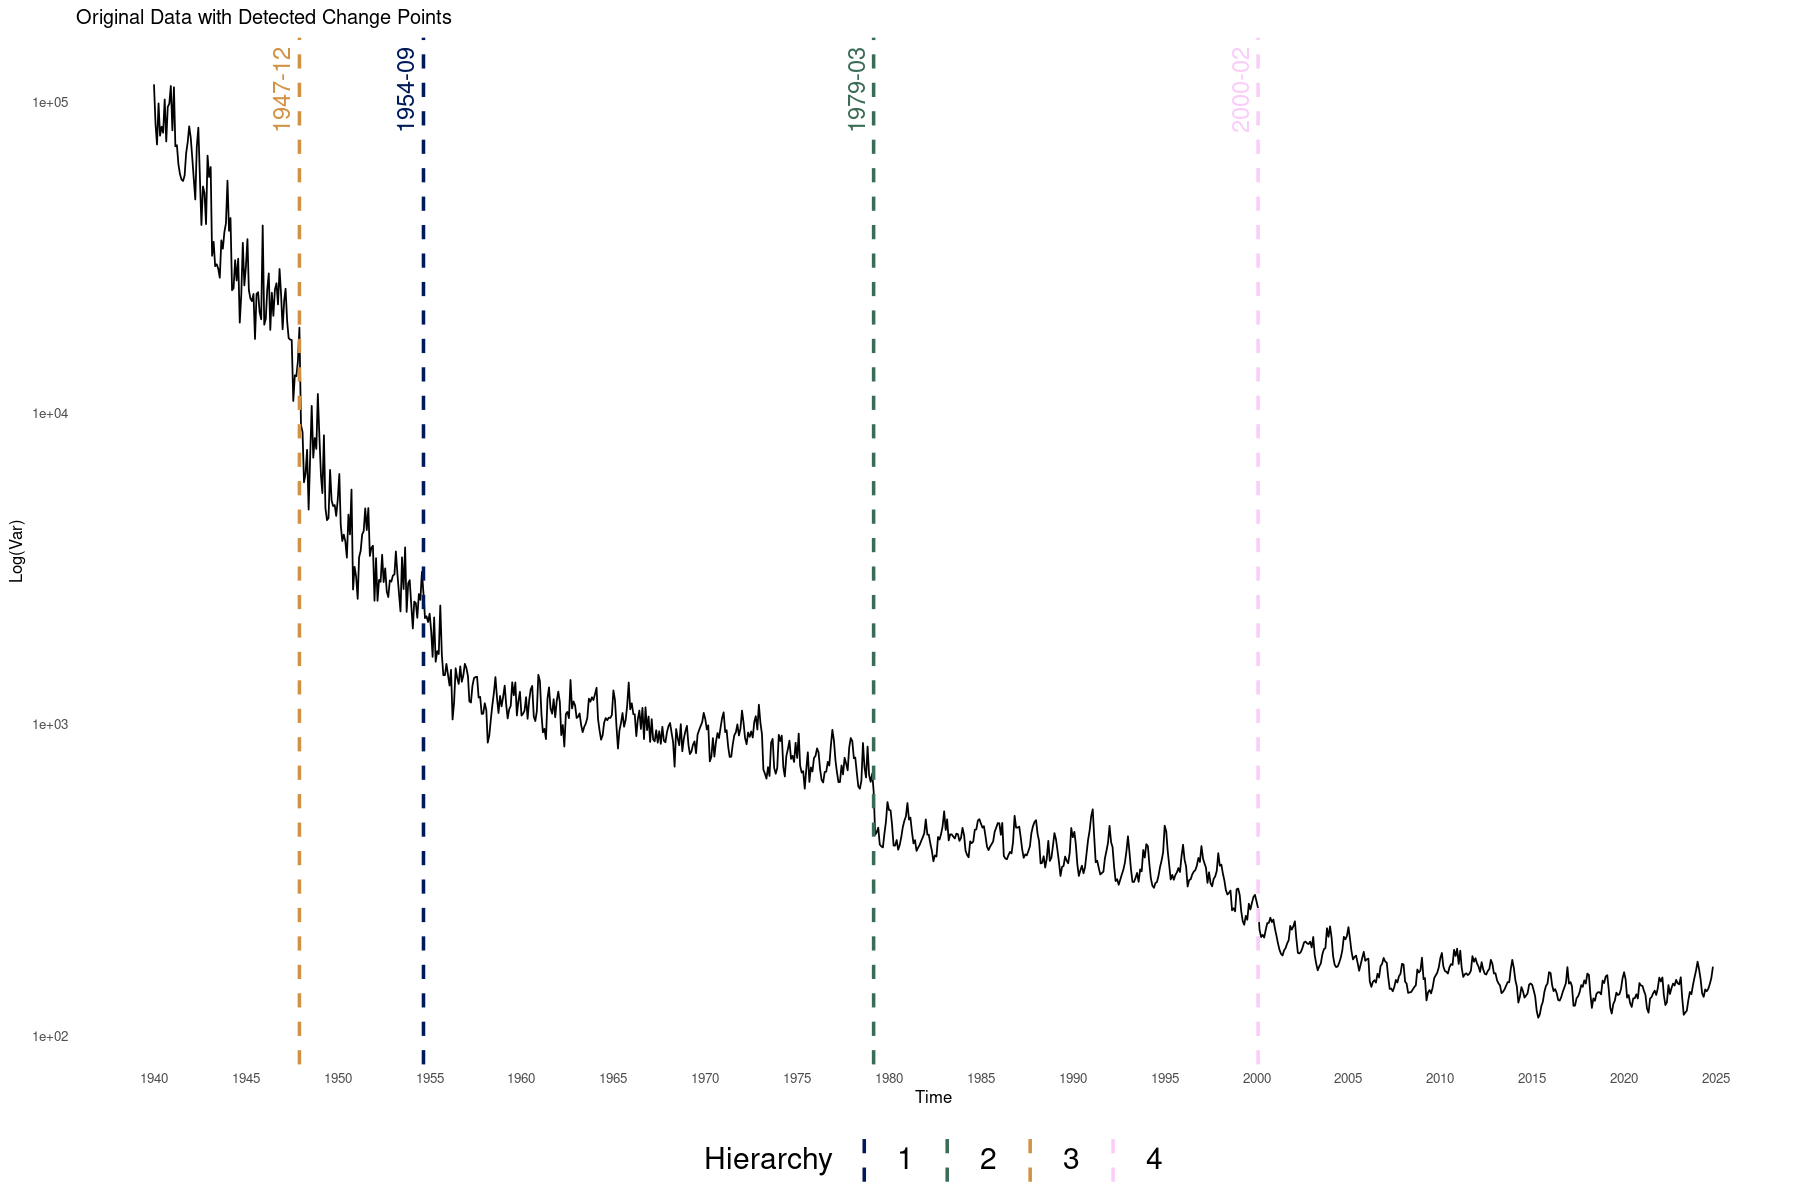

In [4]:
flattened_data <- combined_dataset$avg_z
log_data <- log(flattened_data)

#---------------- Change Point Detection and Plotting ------------------------
max_cp_vec <- 1:4

# Prepare an empty data frame to accumulate change point info:
# cp_index: index in the time series
# cp_date: the corresponding date
# max_cp: the hierarchical level (i.e. the iteration when first found)
cp_df <- data.frame(
    cp_index = integer(),
    cp_date = as.Date(character()),
    max_cp = integer(),
    stringsAsFactors = FALSE
)

# Loop over each max_cp value and detect change points hierarchically.
for (i in seq_along(max_cp_vec)) {
    max_cp <- max_cp_vec[i]
    cpt_obj <- cpt.mean(log_data,
        method = "BinSeg", Q = max_cp,
        class = TRUE
    )
    # cpts() returns the indices of the change points (including the final index)
    cps <- cpts(cpt_obj)
    cps <- cps[cps < length(flattened_data)]

    # Save only newly found change points
    new_cps <- cps[!cps %in% cp_df$cp_index]

    if (length(new_cps) > 0) {
        for (cp in new_cps) {
            cp_df <- rbind(
                cp_df,
                data.frame(
                    cp_index = cp,
                    cp_date = combined_dataset$date[cp],
                    max_cp = max_cp,
                    stringsAsFactors = FALSE
                )
            )
        }
        cat(
            "Max change points:", max_cp,
            "-> New cp detected at indices:", paste(new_cps, collapse = ", "),
            "which correspond to dates:",
            paste(as.character(combined_dataset$date[new_cps]),
                collapse = ", "
            ), "\n"
        )
    } else {
        cat(
            "Max change points:", max_cp,
            "-> No new change points detected.\n"
        )
    }
}

#--- Build the base plot using actual date values on the x-axis ---------------
p <- ggplot(data = combined_dataset, aes(x = date, y = avg_z)) +
    geom_line() +
    scale_y_log10() +
    labs(
        x = "Time", y = "Log(Var)",
        title = "Original Data with Detected Change Points",
        color = "Hierarchy"
    ) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    THEME_PUB +
    scale_x_date(date_breaks = "5 year", date_labels = "%Y") +
    scale_color_scico_d(palette = "batlow") # discrete colour scale

#--- Add vertical lines and annotations for change points --------------------
if (nrow(cp_df) > 0) {
    y_pos <- max(combined_dataset$avg_z, na.rm = TRUE) * .7
    p <- p +
        geom_vline(
            data = cp_df, aes(
                xintercept = cp_date,
                color = factor(max_cp)
            ),
            linetype = "dashed", linewidth = 1
        ) +
        geom_text(
            data = cp_df, aes(
                x = cp_date, y = y_pos,
                label = format(cp_date, "%Y-%m"),
                color = factor(max_cp)
            ),
            angle = 90, vjust = -0.5, hjust = 0, size = 5, show.legend = FALSE
        ) +
        guides(color = guide_legend(
            override.aes = list(
                shape = NA,
                linetype = "dashed"
            )
        )) +
        theme(
            legend.title = element_text(size = 18),
            legend.text = element_text(size = 18),
            legend.key.size = unit(2, "lines")
        )
}

#--- Display the plot ---------------------------------------------------------
print(p)

#--- Print out the exact time values (and indices) identified ----------------
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}


Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


Max change points: 1 -> New cp detected at indices: 722 which correspond to dates: 2000-02-01 


Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


Max change points: 2 -> New cp detected at indices: 188 which correspond to dates: 1955-08-01 


Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


Max change points: 3 -> New cp detected at indices: 471 which correspond to dates: 1979-03-01 


Warning message in BINSEG(sumstat, pen = pen.value, cost_func = costfunc, minseglen = minseglen, :
“The number of changepoints identified is Q, it is advised to increase Q to make sure changepoints have not been missed.”


Max change points: 4 -> New cp detected at indices: 96 which correspond to dates: 1947-12-01 


Detected change points:
  cp_index    cp_date max_cp
1      722 2000-02-01      1
2      188 1955-08-01      2
3      471 1979-03-01      3
4       96 1947-12-01      4


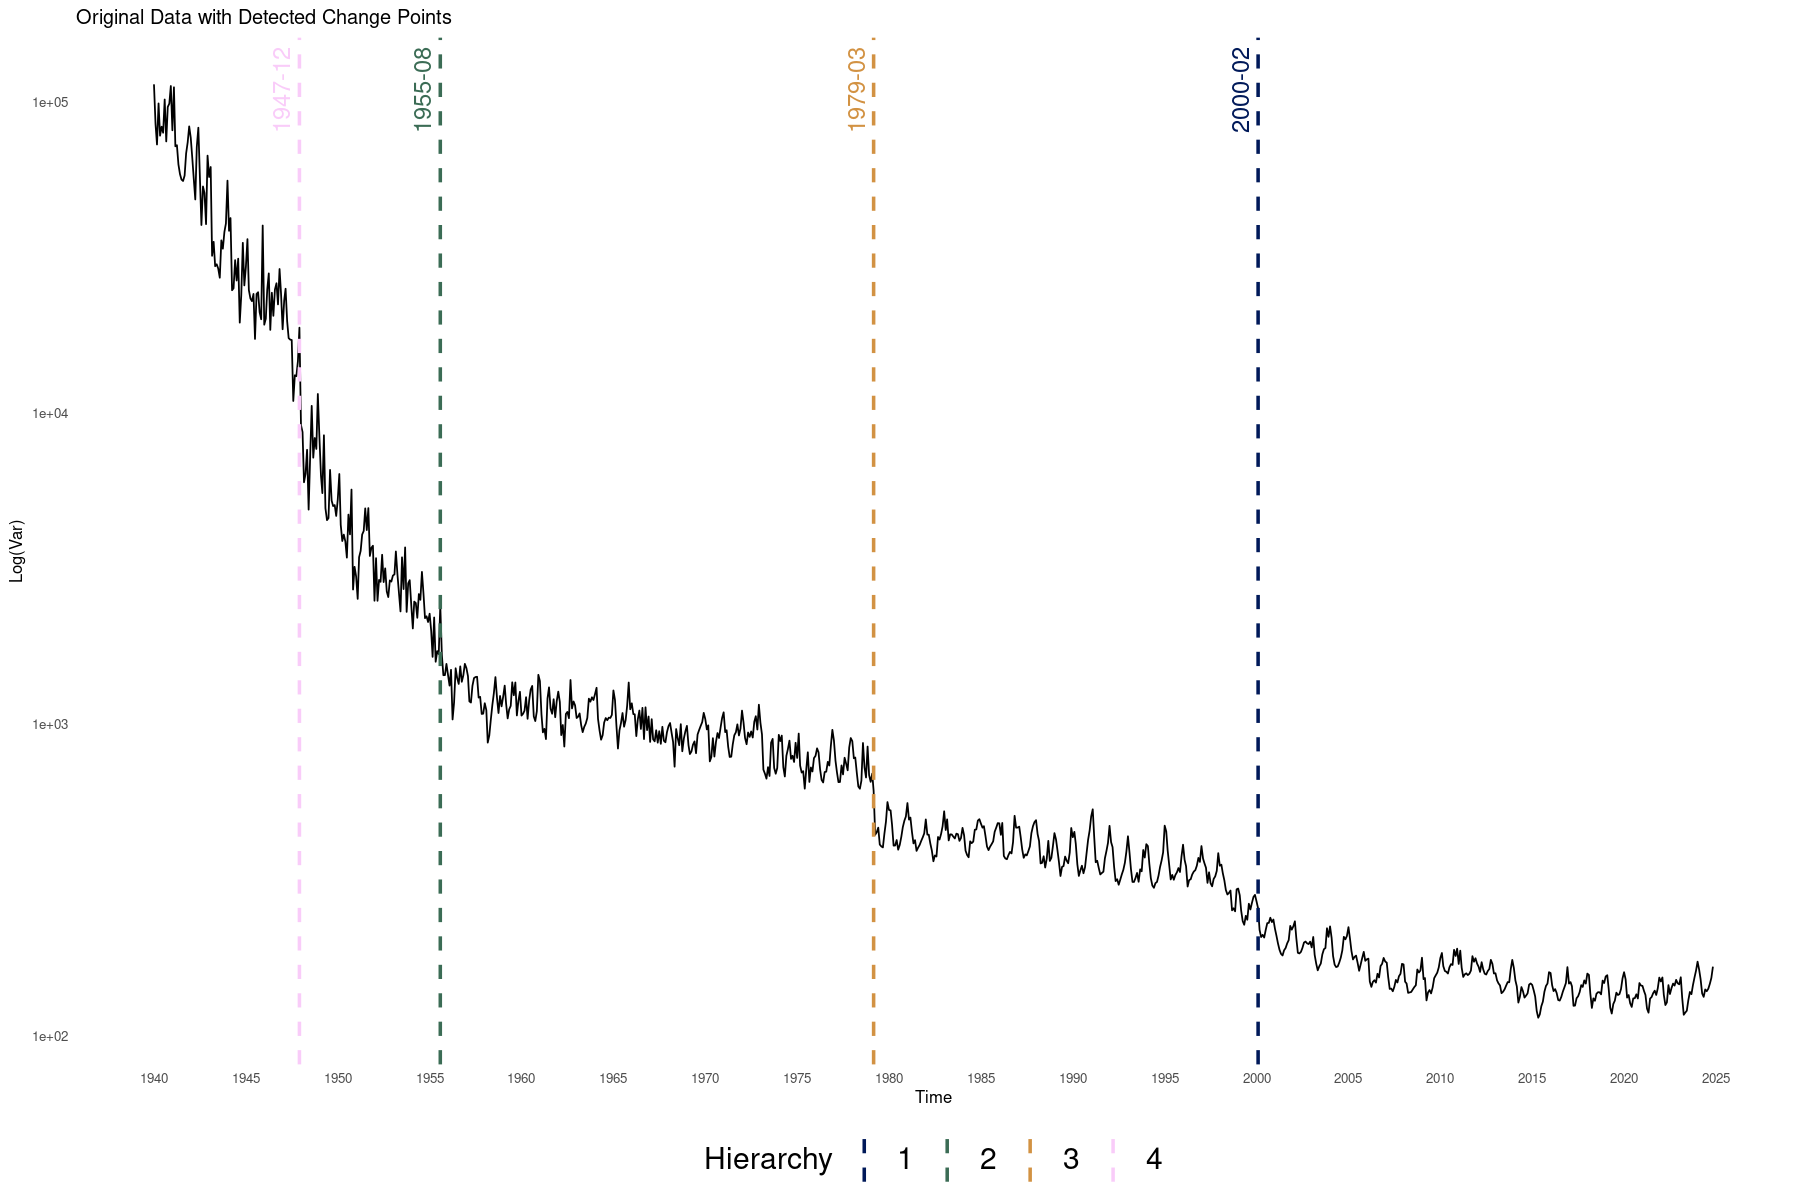

In [5]:
max_cp_vec <- 1:4

# Detect change points
cp_df <- detect_change_points(
    log_data,
    combined_dataset$date,
    max_cp_vec
)

# Create the plot (THEME_PUB can be passed if defined)
p <- plot_change_points(combined_dataset, cp_df, theme_pub = THEME_PUB)

# Display the plot
print(p)

# Print the detected change points
if (nrow(cp_df) > 0) {
    cat("Detected change points:\n")
    print(cp_df)
} else {
    cat("No change points detected in the final run.\n")
}


## Multiple structural change models (Bai & Perron, 2003)
**Challenge:** Choose either max number of breakpoints or minimum segment size?

Lade nötiges Paket: sandwich


Attache Paket: ‘strucchange’


Das folgende Objekt ist maskiert ‘package:stringr’:

    boundary




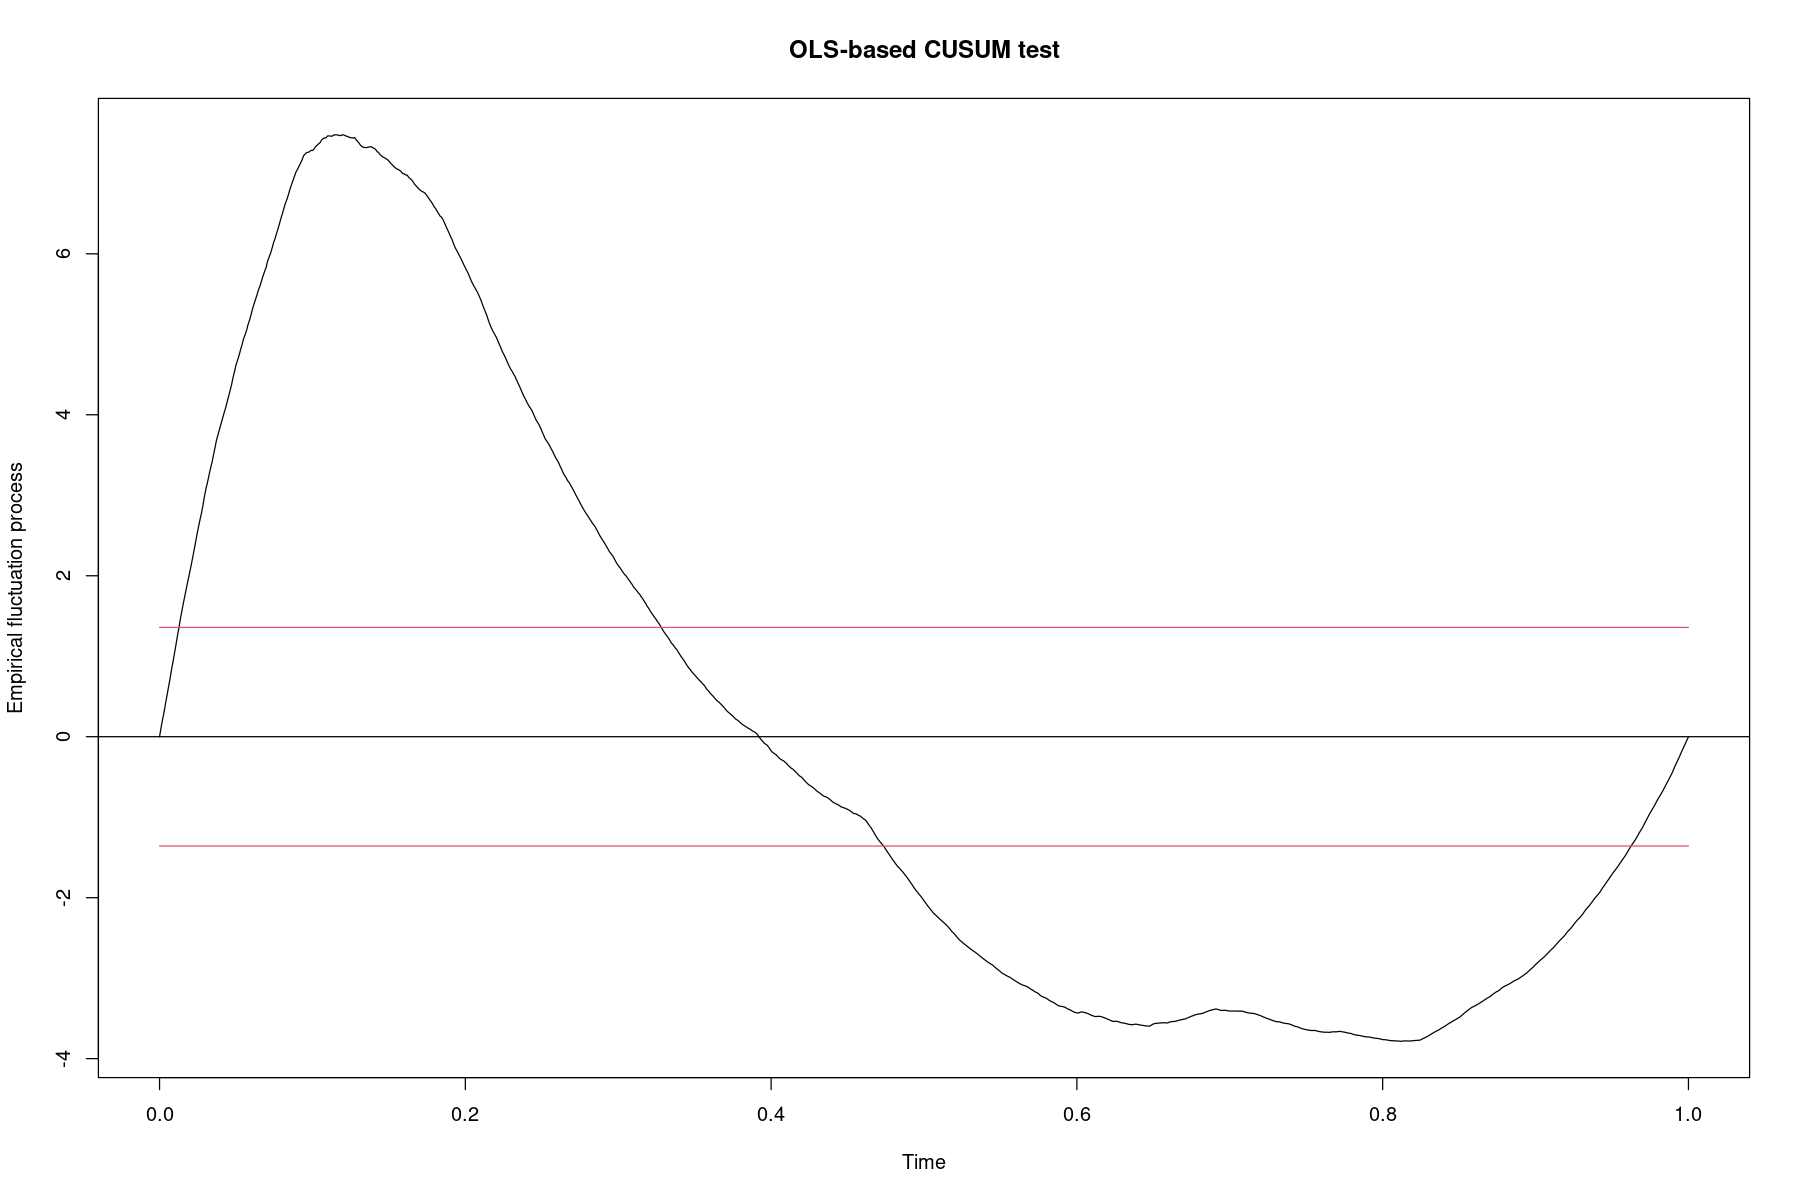

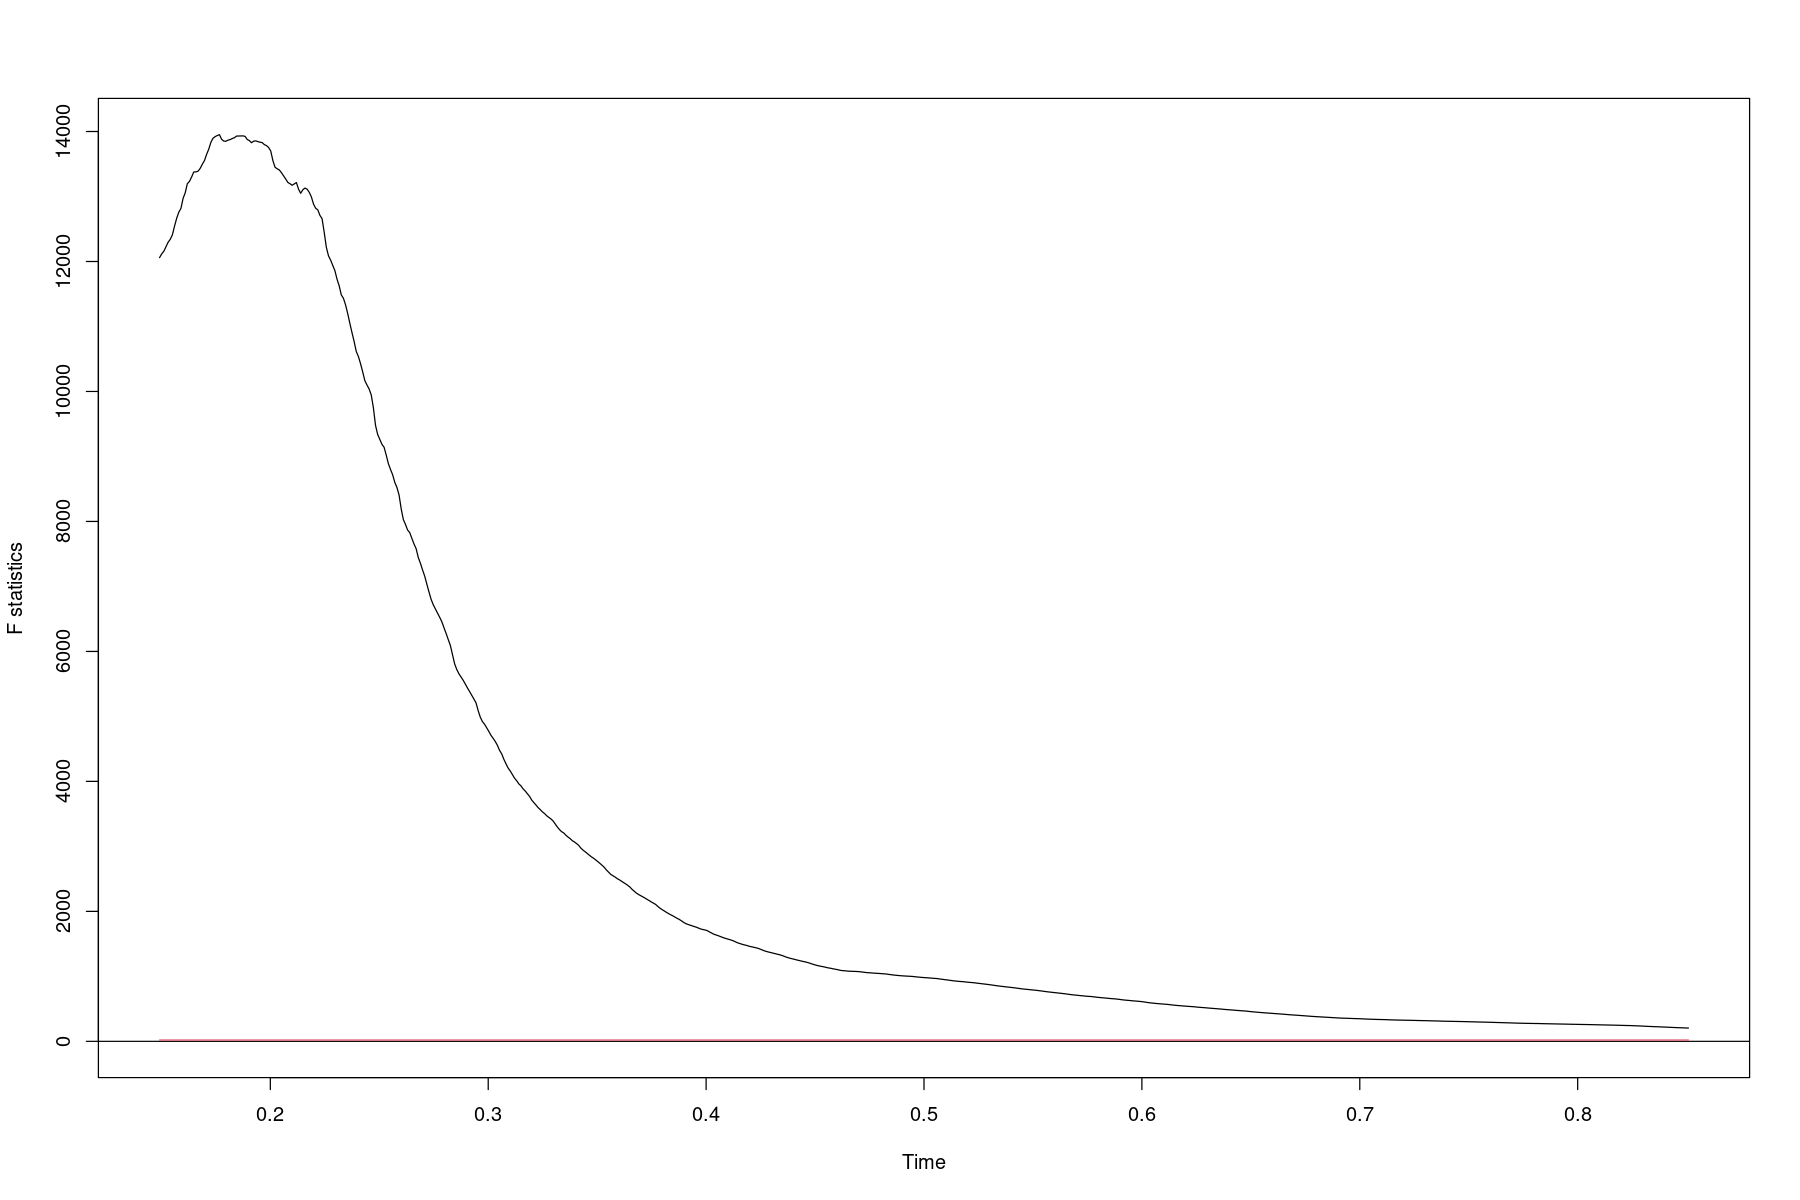

In [4]:
model_formula <- (log_variance ~ year + sin_mon + cos_mon +
    year:sin_mon + year:cos_mon)
par(bg = "white")

ocus <- efp(
    formula = model_formula,
    data = combined_dataset,
    type = "OLS-CUSUM"
)

plot(ocus)

fs <- Fstats(model_formula, data = combined_dataset)
plot(fs)


pdf 
  2


	 Optimal 6-segment partition: 

Call:
breakpoints.formula(formula = model_formula, h = 0.1, data = combined_dataset)

Breakpoints at observation number:
101 221 470 704 835 

Corresponding to breakdates:
0.09911678 0.2168793 0.4612365 0.6908734 0.8194308 

	 Confidence intervals for breakpoints
	 of optimal 6-segment partition: 

Call:
confint.breakpointsfull(object = bp_est_monthly, level = 0.99)

Breakpoints at observation number:
  0.5 % breakpoints 99.5 %
1    93         101    103
2   220         221    223
3   469         470    471
4   703         704    706
5   834         835    838

Corresponding to breakdates:
       0.5 % breakpoints    99.5 %
1 0.09126595  0.09911678 0.1010795
2 0.21589794  0.21687929 0.2188420
3 0.46025515  0.46123651 0.4622179
4 0.68989205  0.69087341 0.6928361
5 0.81844946  0.81943081 0.8223749


cp_date,cp_date_lower,cp_date_upper,cp_no
<date>,<date>,<date>,<int>
1958-05-01,1958-04-01,1958-07-01,1
1998-08-01,1998-07-01,1998-10-01,2
1979-02-01,1979-01-01,1979-03-01,3
1948-05-01,1947-09-01,1948-07-01,4
2009-07-01,2009-06-01,2009-10-01,5


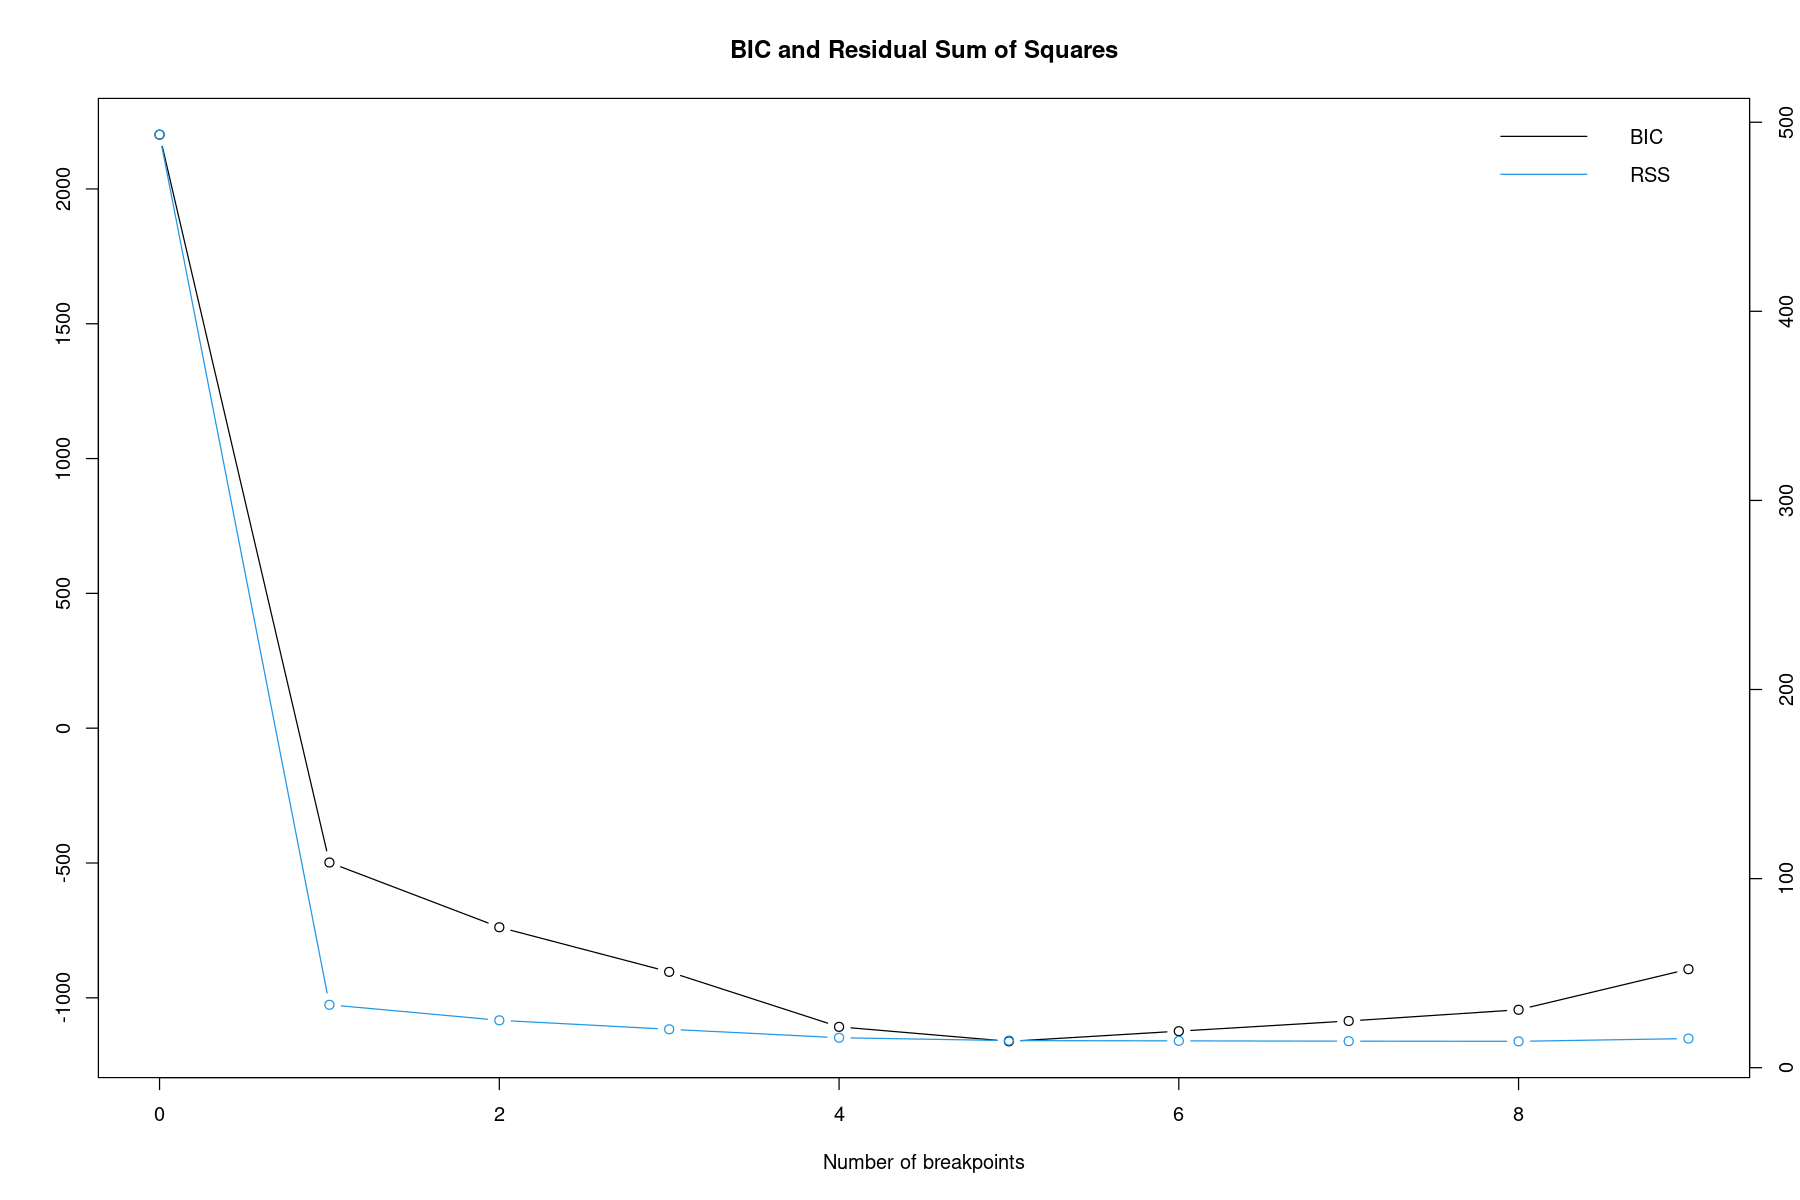

In [5]:
# Estimate breakpoints
bp_est_monthly <- breakpoints(model_formula, data = combined_dataset, h = .1)
par(bg = "white")
plot(bp_est_monthly)
pdf(paste0(OUT_DIR, "BIC_breakpoints.pdf"), width = 4, height = 3)
plot(bp_est_monthly)
dev.off()
print(bp_est_monthly)
print(confint(bp_est_monthly, level = 0.99))

cp_df <- ordered_cp_df(bp_est_monthly, combined_dataset)
cp_df


In [6]:
combined_dataset$segment <- breakfactor(bp_est_monthly)


# Fit the segmented linear model with segment-specific predictors
lmod_seas_monthly <- lm(
    log_variance ~ segment +
        segment:year + segment:sin_mon + segment:cos_mon +
        segment:year:sin_mon + segment:year:cos_mon - 1,
    data = combined_dataset
)

# Summarize the segmented model results
summary(lmod_seas_monthly)



Call:
lm(formula = log_variance ~ segment + segment:year + segment:sin_mon + 
    segment:cos_mon + segment:year:sin_mon + segment:year:cos_mon - 
    1, data = combined_dataset)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.66553 -0.06105 -0.00417  0.06306  0.55193 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
segmentsegment1               5.090e+02  9.762e+00  52.144  < 2e-16 ***
segmentsegment2               3.780e+02  7.487e+00  50.483  < 2e-16 ***
segmentsegment3               5.838e+01  2.522e+00  23.151  < 2e-16 ***
segmentsegment4               4.348e+01  2.798e+00  15.537  < 2e-16 ***
segmentsegment5               1.117e+02  6.731e+00  16.600  < 2e-16 ***
segmentsegment6               2.826e+01  4.075e+00   6.936 7.33e-12 ***
segmentsegment1:year         -2.565e-01  5.023e-03 -51.071  < 2e-16 ***
segmentsegment2:year         -1.895e-01  3.834e-03 -49.428  < 2e-16 ***
segmentsegment3:year         -2.618e-02  1.281e-03 -2

In [8]:
str(cp_df)


'data.frame':	5 obs. of  4 variables:
 $ cp_date      : Date, format: "1958-05-01" "1998-08-01" ...
 $ cp_date_lower: Date, format: "1958-04-01" "1998-07-01" ...
 $ cp_date_upper: Date, format: "1958-07-01" "1998-10-01" ...
 $ cp_no        : int  1 2 3 4 5


Warning message:
“Using size for a discrete variable is not advised.”


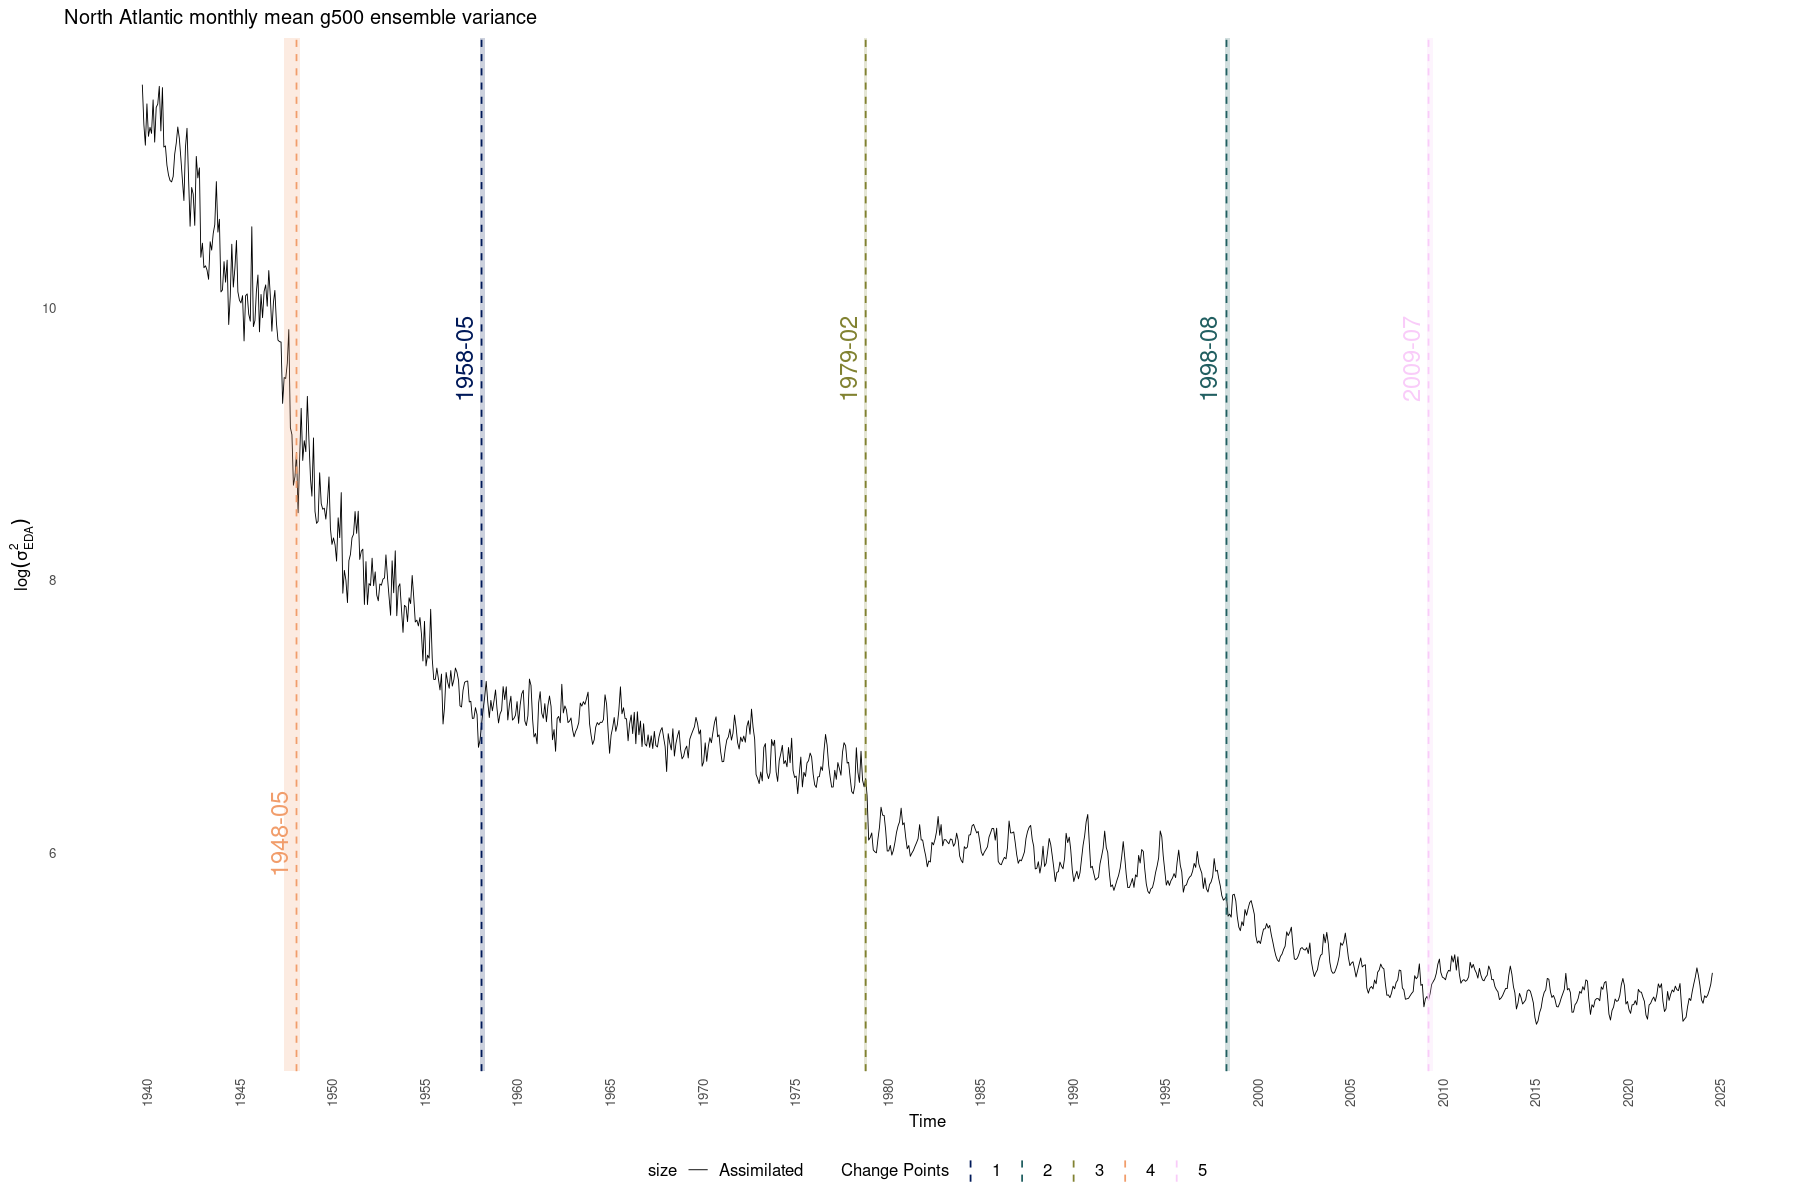

pdf 
  2

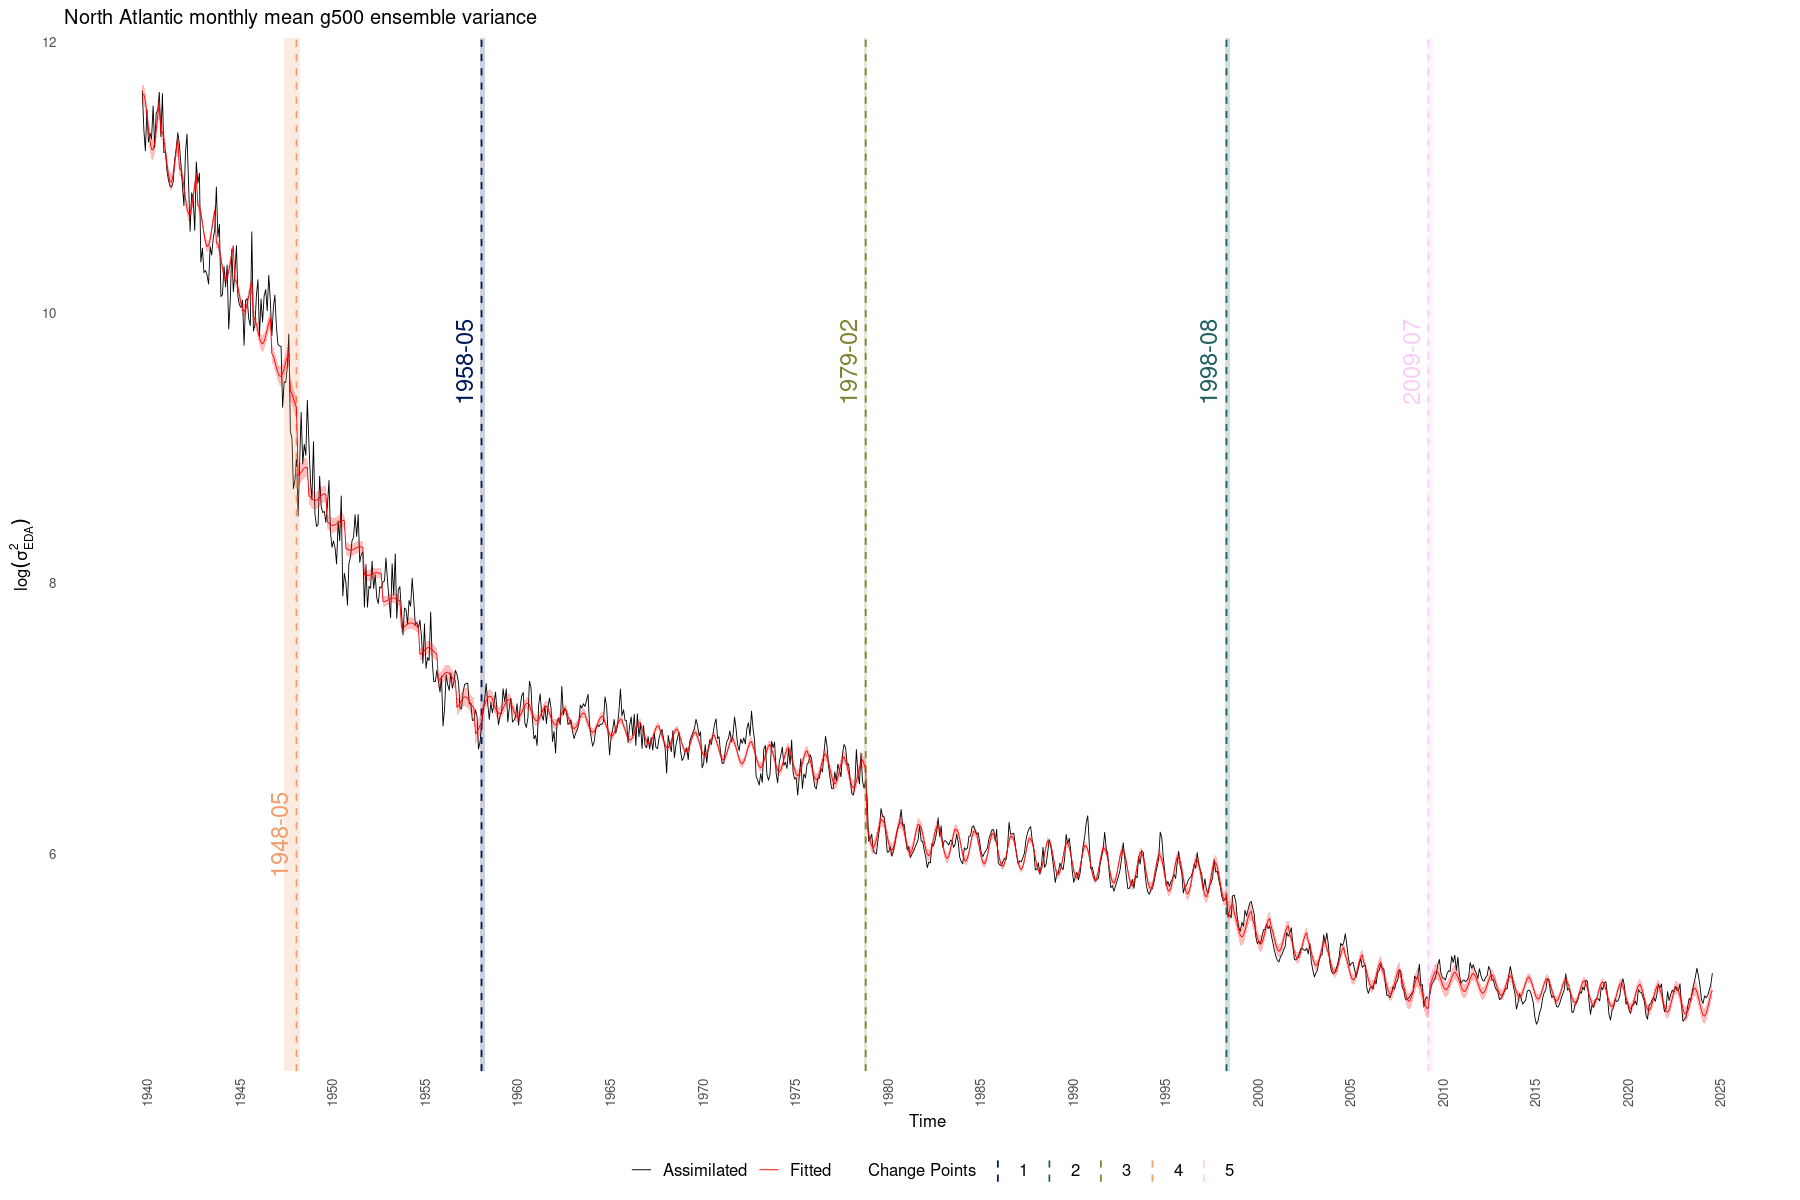

pdf 
  2

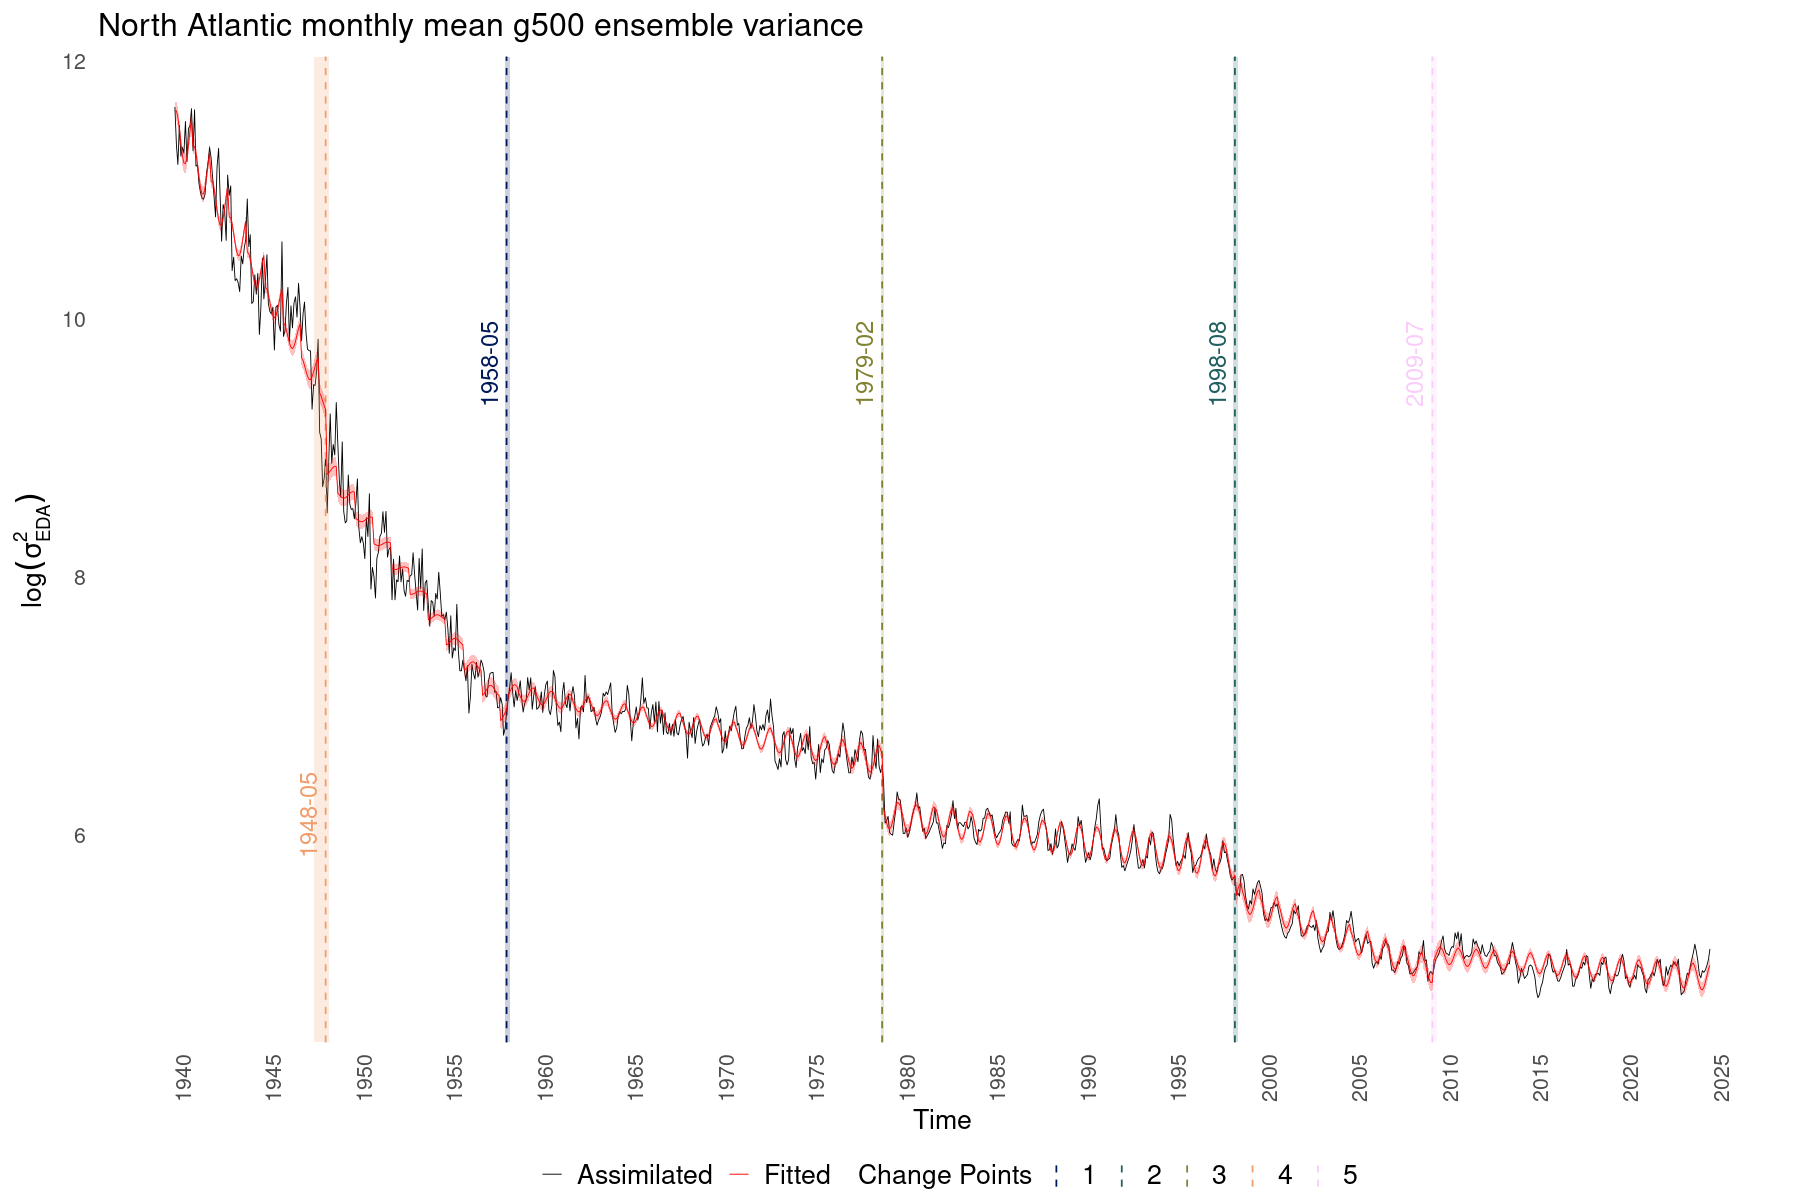

In [11]:
p <- plot_change_points(
    data = combined_dataset,
    cp_df = cp_df,
    theme_pub = NULL,
    show_ci = TRUE
)
p



fitted_layers <- add_fitted_line_ci(lmod_seas_monthly, combined_dataset)
for (layer in fitted_layers) {
    p <- p + layer
}

# Optional: Combine the legends for size and linetype into one "Data" legend
p <- p + guides(
    size = guide_legend(order = 1),
    linetype = guide_legend(order = 2),
    color = guide_legend(order = 3)
)

p

save_plot(p, "ChangePoints.pdf")

p <- p + THEME_PUB_LARGE
p
save_plot(p, "ChangePointsLarge.pdf", width = 9.5, height = 4.25)
